Loading Libraries

In [40]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import*
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

Preparing Dataset

In [41]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
dataset = read_csv(url, header=None)
data = dataset.values
x_data, y_data = data[:, :-1],data[:, -1]
x_data = pd.DataFrame(x_data.astype('float64'))
# Label Encoding Target
###  (M) Mines are now 1 and (R) Rocks are now 0
le = preprocessing.LabelEncoder()
le.fit(y_data)
y_data = le.transform(y_data)
y_data = pd.DataFrame(y_data.astype('float64'))

SpotOnCheck: Compare Classifier

neg_log_loss
RF: -0.528297 (0.100396)
CatB: -0.496067 (0.122141)
lgbm: -0.595345 (0.270097)
xgb: -0.657288 (0.254911)
GBC: -0.725244 (0.371779)
ADA: -0.644955 (0.035297)
LR: -0.615503 (0.210389)
SVM: -0.729842 (0.242143)
DC: -0.690984 (0.002031)


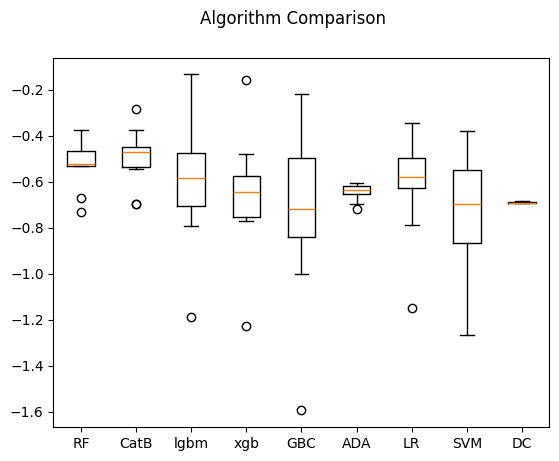

In [42]:
# append models
models = []
#models.append(('ET', ExtraTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CatB', CatBoostClassifier(verbose=False)))
models.append(('lgbm', LGBMClassifier(verbose=-1)))
models.append(('xgb', XGBClassifier()))
#models.append(('ridge',  RidgeClassifier()))
models.append(('GBC',  GradientBoostingClassifier()))
models.append(('ADA',  AdaBoostClassifier()))
models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(probability=True)))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('DC', DummyClassifier()))
results = []
results_std = []
names = []
scoring = 'neg_log_loss'
print(scoring)
# Set Cross-Validation
kfold = StratifiedKFold(n_splits=10, random_state=None)
for name, model in models:   
    cv_results = cross_val_score(model, x_data, y_data, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #results_std.append(cv_results.std())
    mean_scoring = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(mean_scoring)
# Create a Dataframe with the results for possible later processing
#df_SpotonCheck = pd.DataFrame({'name': names, 'Logloss': results, 'Std': results_std})
# Classifier Comparision Boxplot
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Findings: SpotOnCheck  
Based on the logloss results, we will pick a few tree-based models and since logistic regression is surprisingly good, we will take that too.

SpotOnCheck Ensembles